In [1]:
# importo tutti i vari moduli di Python
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
        #pyplot serve per generare le figure
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
# from ... import ... così non devo mettere nessun prefisso 
# ogni volta che vado a richiamare il pacchetto importato
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.5.0


In [3]:
from IPython.display import display, clear_output
import PIL
def animate_solution(images, timestamps=None):
    def animate(i):
        changed_artifacts = [im]
        im.set_data(images[i])
        if timestamps is not None:
            time_text.set_text(timestamps[i])
            changed_artifacts.append(im)
        return tuple(changed_artifacts)

    
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    if timestamps is not None:
        time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes)

    anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=60, blit=True)
    
    # To prevent plotting image inline.
    plt.close()
    return anim

In [4]:
# RASTERIZER CLASS

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/Users/Alberto/Documents/AAB Documents/Python prova/Dataset"
cfg=load_config_data("/Users/Alberto/Documents/AAB Documents/Python prova/Dataset/visualisation_config.yaml")
#cfg non è altro che il contenuto del file visualization_config.yaml
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


In [6]:
dm = LocalDataManager()
#Ci dice che i dati che ci servono sono all’interno di una cartella specifica.
dataset_path = dm.require('/Users/Alberto/Documents/AAB Documents/Python prova/Dataset/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
#ChunkedDataset is a dataset that lives on disk in compressed chunks, 
#it has easy to use data loading and writing interfaces that involves making numpy-like slices. 
#Currently only .zarr directory stores are supported 
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
def visualize_rgb_image(dataset, index, title="", ax=None):
    """Visualizes Rasterizer's RGB image"""
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)

    if ax is None:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.imshow(im[::-1])

In [8]:
rasterizer_dict = {}
dataset_dict={}

#rasterizer_dict è composto dalla lista di parametri di rasterizer_type_list.
#Come tipologia di file è un file dict (insieme di valori key)
rasterizer_type_list = ["stub_debug", "satellite_debug", "semantic_debug", "box_debug", "py_satellite", "py_semantic"]

for i, key in enumerate(rasterizer_type_list):
    print(str(i) + '   ' + key)
    cfg["raster_params"]["map_type"] = key
    rasterizer_dict[key] = build_rasterizer(cfg, dm)
    dataset_dict[key] = EgoDataset(cfg, zarr_dataset, rasterizer_dict[key])
    
#noto che all'inizio rasterizer_dict e dataset_dict sono stati inseriti come insiemi vuoti {}
#durante il ciclo if i loro valori vengono aggiornati ad ogni iterazione

0   stub_debug
1   satellite_debug
2   semantic_debug
3   box_debug
4   py_satellite
5   py_semantic


In [9]:
# DEFINISCO FRAME
#cambiando index cambia IL FRAME visualizzato
#nell'esempio i FRAME sono 24838. Il vengono numerati a partire dallo 0
#quindi posso visualizzare i frame dal numero 0 al numero 24837.

frame_idx=0
print(frame_idx, type(frame_idx))

0 <class 'int'>


In [10]:
#DEFINISCO SCENA
#cambiando scene_idx cambia LA SCENA visualizzata
#nell'esempio le SCENE sono 100. 

scene_idx = 0
print(scene_idx, type(scene_idx))

0 <class 'int'>


0   stub_debug
1   satellite_debug
2   semantic_debug
3   box_debug
4   py_satellite
5   py_semantic


/var/folders/5r/4hgfmgmd0wj4bmfwt33twxxm0000gn/T/ipykernel_3861/2354610784.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



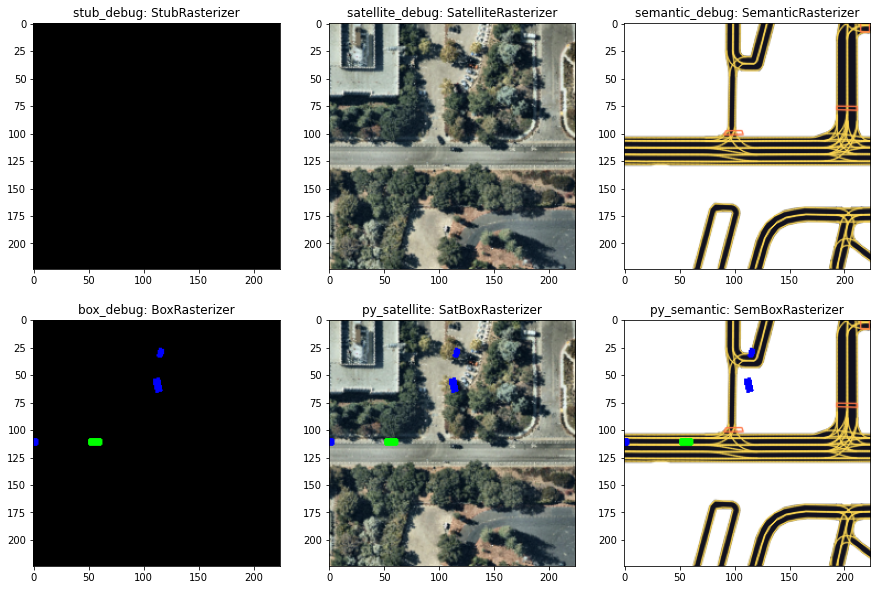

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, key in enumerate(rasterizer_type_list):
    print(str(i) + '   ' + key)
    visualize_rgb_image(dataset_dict[key], frame_idx, title=f"{key}: {type(rasterizer_dict[key]).__name__}", ax=axes[i])
    fig.show()

In [59]:
def create_animate_for_indexes(dataset, indexes):
    images = []
    timestamps = []

    for idx in indexes:
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
        timestamps.append(data["timestamp"])

    anim = animate_solution(images, timestamps)
    return anim

def create_animate_for_scene(dataset, scene_idx):
    indexes = dataset.get_scene_indices(scene_idx)
    return create_animate_for_indexes(dataset, indexes)

In [61]:
#MANCA LA CELLA IN CUI VISUALIZZO UNA SCENA INTERA (una scena è l'insieme di più fotogrammi)
#CI SONO SICURAMENTE PROBLEMI CON LA VARIABILE 'dataset'

dataset = dataset_dict['py_semantic']
#anim = create_animate_for_indexes(dataset, scene_idx)
print("scene_idx", scene_idx)
#HTML(anim.to_jshtml())

TypeError: 'int' object is not iterable

In [54]:
# EGO DATASET

In [15]:
semantic_rasterizer = rasterizer_dict["py_semantic"]
dataset = dataset_dict["py_semantic"]

In [16]:
# punto in cui finisce una scena e ne comincia un'altra
print("Lunghezza cumulata delle scene", dataset.cumulative_sizes)

# lunghezza di una scena
print("Lunghezza di ogni scena in frames", dataset.cumulative_sizes[1:] - dataset.cumulative_sizes[:-1])
#noto che la lunghezza di ogni scena si aggira attorno ai 248/249 frames

Lunghezza cumulata delle scene [  248   497   746   995  1244  1493  1742  1991  2240  2489  2738  2987
  3236  3485  3734  3983  4232  4481  4730  4979  5228  5477  5725  5973
  6221  6469  6717  6965  7213  7461  7709  7957  8205  8453  8701  8949
  9197  9445  9693  9941 10189 10437 10685 10933 11182 11431 11680 11929
 12177 12425 12673 12921 13169 13417 13665 13913 14161 14409 14657 14905
 15153 15401 15649 15897 16145 16393 16641 16889 17137 17385 17633 17881
 18129 18377 18625 18874 19123 19372 19621 19870 20118 20366 20614 20862
 21110 21358 21607 21856 22105 22354 22603 22852 23101 23350 23598 23846
 24094 24342 24590 24838]
Lunghezza di ogni scena in frames [249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249
 249 249 249 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248
 248 248 248 248 248 248 248 249 249 249 249 248 248 248 248 248 248 248
 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248
 248 248 249 249 249 249 249 248 

In [40]:
# il frame di riferimento è l'attributo frame_idx definito prima
data = dataset[frame_idx]

print("ego dataset[", frame_idx,"]=data is ", type(data))

def _describe(value):
    if hasattr(value, "shape"):
        return f"{type(value).__name__:20} shape={value.shape}"
    else:
        return f"{type(value).__name__:20} value={value}"

for key, value in data.items():
    print("  ", f"{key:25}", _describe(value))
    
# dalle cose stampate vedo che il frame (frame_frame_idx) entra all'interno
# di una data scena (scene_frame_idx)

ego dataset[ 0 ]=data is  <class 'dict'>
   frame_index               int                  value=0
   image                     ndarray              shape=(5, 224, 224)
   target_positions          ndarray              shape=(50, 2)
   target_yaws               ndarray              shape=(50, 1)
   target_velocities         ndarray              shape=(50, 2)
   target_availabilities     ndarray              shape=(50,)
   history_positions         ndarray              shape=(1, 2)
   history_yaws              ndarray              shape=(1, 1)
   history_velocities        ndarray              shape=(0, 2)
   history_availabilities    ndarray              shape=(1,)
   world_to_image            ndarray              shape=(3, 3)
   raster_from_agent         ndarray              shape=(3, 3)
   raster_from_world         ndarray              shape=(3, 3)
   agent_from_world          ndarray              shape=(3, 3)
   world_from_agent          ndarray              shape=(3, 3)
   centroid 

In [18]:
frame_indices = dataset.get_scene_indices(scene_idx)
print(f"frame_indices for scene {scene_idx} = {frame_indices}")

scene_dataset = dataset.get_scene_dataset(scene_idx)
print(f"scene_dataset {type(scene_dataset).__name__}, length {len(scene_dataset)}")

# Animate whole "scene_dataset"
#create_animate_for_indexes(scene_dataset, np.arange(len(scene_dataset)))

frame_indices for scene 0 = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 23

/usr/local/Cellar/jupyterlab/3.1.14_1/libexec/lib/python3.9/site-packages/l5kit/data/zarr_dataset.py:213: RuntimeWarning:

zarr dataset path should end with .zarr (for now). Open will fail for this dataset!



In [19]:
# AGENT DATASET

In [20]:
semantic_rasterizer = rasterizer_dict["py_semantic"]
agent_dataset = AgentDataset(cfg, zarr_dataset, semantic_rasterizer)

In [21]:
# The returned data structure is same.
# il frame di riferimento è l'attributo frame_idx definito prima
data = agent_dataset[frame_idx]

print("agent dataset[", frame_idx,"]=data is ", type(data))

def _describe(value):
    if hasattr(value, "shape"):
        return f"{type(value).__name__:20} shape={value.shape}"
    else:
        return f"{type(value).__name__:20} value={value}"

for key, value in data.items():
    print("  ", f"{key:25}", _describe(value))

agent dataset[ 0 ]=data is  <class 'dict'>
   frame_index               int                  value=11
   image                     ndarray              shape=(5, 224, 224)
   target_positions          ndarray              shape=(50, 2)
   target_yaws               ndarray              shape=(50, 1)
   target_velocities         ndarray              shape=(50, 2)
   target_availabilities     ndarray              shape=(50,)
   history_positions         ndarray              shape=(1, 2)
   history_yaws              ndarray              shape=(1, 1)
   history_velocities        ndarray              shape=(0, 2)
   history_availabilities    ndarray              shape=(1,)
   world_to_image            ndarray              shape=(3, 3)
   raster_from_agent         ndarray              shape=(3, 3)
   raster_from_world         ndarray              shape=(3, 3)
   agent_from_world          ndarray              shape=(3, 3)
   world_from_agent          ndarray              shape=(3, 3)
   centro

In [22]:
frame_indices = agent_dataset.get_scene_indices(scene_idx)
print(f"frame_indices for scene {scene_idx} = {frame_indices}")

scene_dataset = agent_dataset.get_scene_dataset(scene_idx)
print(f"scene_dataset {type(scene_dataset).__name__}, length {len(scene_dataset)}")

# Animate whole "scene_dataset"
#create_animate_for_indexes(scene_dataset, np.arange(len(scene_dataset)))

frame_indices for scene 0 = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
scene_dataset AgentDataset, length 35


/usr/local/Cellar/jupyterlab/3.1.14_1/libexec/lib/python3.9/site-packages/l5kit/dataset/agent.py:139: RuntimeWarning:

you're running with a custom agents_mask



In [24]:
for i in range(24837):
    print(i, agent_dataset.get_frame_indices(i))

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 [0]
12 [1]
13 [2]
14 [3]
15 [4]
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 [5]
68 [6]
69 [7]
70 [8]
71 [9]
72 [10]
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 [11]
103 [12]
104 [13]
105 [14]
106 [15]
107 [16]
108 [17]
109 [18]
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []
146 []
147 []
148 []
149 []
150 []
151 []
152 []
153 []
154 

970 [842]
971 [843]
972 [844 845]
973 [846 847]
974 [848 849]
975 [850]
976 [851]
977 [852]
978 [853]
979 [854]
980 [855]
981 [856]
982 [857 858]
983 [859 860]
984 [861 862]
985 [863 864]
986 [865 866]
987 [867 868]
988 [869 870 871 872]
989 [873 874 875 876]
990 [877 878 879]
991 [880 881 882]
992 [883 884 885]
993 [886 887 888]
994 []
995 []
996 []
997 []
998 []
999 []
1000 []
1001 []
1002 []
1003 []
1004 []
1005 [889]
1006 [890 891]
1007 [892 893]
1008 [894 895]
1009 [896 897]
1010 [898 899]
1011 [900 901]
1012 [902 903]
1013 [904 905]
1014 [906 907]
1015 [908 909]
1016 [910 911]
1017 [912 913]
1018 [914 915 916 917]
1019 [918 919]
1020 [920]
1021 [921]
1022 [922]
1023 [923]
1024 [924]
1025 [925 926]
1026 [927 928]
1027 [929 930]
1028 [931 932]
1029 [933 934]
1030 [935 936]
1031 [937 938]
1032 [939 940]
1033 [941 942]
1034 [943 944]
1035 [945 946]
1036 [947]
1037 [948]
1038 [949]
1039 [950]
1040 [951]
1041 [952]
1042 [953]
1043 [954]
1044 [955]
1045 [956]
1046 [957]
1047 [958 959]
1

1719 [2120]
1720 [2121]
1721 [2122]
1722 [2123]
1723 [2124]
1724 [2125]
1725 [2126]
1726 [2127]
1727 [2128]
1728 [2129]
1729 [2130]
1730 [2131]
1731 [2132]
1732 [2133]
1733 [2134]
1734 [2135]
1735 [2136]
1736 [2137 2138]
1737 [2139 2140]
1738 [2141]
1739 [2142]
1740 [2143]
1741 []
1742 []
1743 []
1744 []
1745 []
1746 []
1747 []
1748 []
1749 []
1750 []
1751 []
1752 []
1753 [2144]
1754 []
1755 []
1756 []
1757 []
1758 []
1759 []
1760 []
1761 []
1762 []
1763 []
1764 []
1765 []
1766 []
1767 []
1768 []
1769 []
1770 []
1771 []
1772 []
1773 []
1774 []
1775 []
1776 []
1777 []
1778 []
1779 []
1780 []
1781 []
1782 []
1783 []
1784 []
1785 []
1786 []
1787 []
1788 []
1789 []
1790 []
1791 []
1792 []
1793 []
1794 []
1795 []
1796 []
1797 []
1798 []
1799 []
1800 []
1801 []
1802 []
1803 []
1804 []
1805 []
1806 []
1807 []
1808 [2145]
1809 []
1810 []
1811 []
1812 []
1813 []
1814 []
1815 []
1816 []
1817 []
1818 []
1819 []
1820 []
1821 []
1822 []
1823 []
1824 []
1825 []
1826 []
1827 []
1828 []
1829 []
1830 [

2469 [3102 3103 3104]
2470 [3105 3106 3107]
2471 [3108 3109 3110]
2472 [3111 3112 3113 3114]
2473 [3115 3116 3117 3118]
2474 [3119 3120 3121 3122]
2475 [3123 3124 3125 3126]
2476 [3127 3128 3129 3130]
2477 [3131 3132 3133 3134]
2478 [3135 3136 3137 3138]
2479 [3139 3140 3141 3142]
2480 [3143 3144 3145 3146]
2481 [3147 3148 3149 3150]
2482 [3151 3152 3153 3154]
2483 [3155 3156 3157 3158]
2484 [3159 3160 3161 3162]
2485 [3163 3164 3165 3166]
2486 [3167 3168 3169 3170]
2487 [3171 3172 3173 3174]
2488 []
2489 []
2490 []
2491 []
2492 []
2493 []
2494 []
2495 []
2496 []
2497 []
2498 []
2499 []
2500 [3175]
2501 []
2502 []
2503 [3176]
2504 [3177]
2505 [3178]
2506 [3179]
2507 [3180]
2508 [3181]
2509 [3182]
2510 [3183]
2511 [3184]
2512 [3185]
2513 [3186]
2514 [3187]
2515 [3188]
2516 [3189]
2517 [3190 3191]
2518 [3192 3193]
2519 [3194 3195]
2520 [3196 3197]
2521 [3198 3199]
2522 [3200 3201]
2523 [3202 3203]
2524 [3204 3205]
2525 [3206 3207]
2526 [3208 3209]
2527 [3210 3211]
2528 [3212 3213]
2529 [

3219 [5887 5888 5889 5890 5891 5892 5893]
3220 [5894 5895 5896 5897 5898 5899 5900 5901 5902]
3221 [5903 5904 5905 5906 5907 5908 5909 5910]
3222 [5911 5912 5913 5914 5915 5916 5917 5918]
3223 [5919 5920 5921 5922 5923 5924 5925 5926]
3224 [5927 5928 5929 5930 5931 5932 5933 5934]
3225 [5935 5936 5937 5938 5939 5940 5941 5942]
3226 [5943 5944 5945 5946 5947 5948 5949]
3227 [5950 5951 5952 5953 5954 5955 5956]
3228 [5957 5958 5959 5960 5961 5962 5963]
3229 [5964 5965 5966 5967 5968 5969 5970]
3230 [5971 5972 5973 5974 5975 5976 5977 5978]
3231 [5979 5980 5981 5982 5983 5984 5985 5986]
3232 [5987 5988 5989 5990 5991 5992 5993 5994]
3233 [5995 5996 5997 5998 5999 6000 6001 6002]
3234 [6003 6004 6005 6006 6007 6008 6009]
3235 []
3236 []
3237 []
3238 []
3239 []
3240 []
3241 []
3242 []
3243 []
3244 []
3245 []
3246 [6010 6011]
3247 [6012 6013 6014 6015 6016 6017]
3248 [6018 6019 6020 6021 6022 6023]
3249 [6024 6025 6026 6027 6028 6029]
3250 [6030 6031 6032 6033 6034 6035 6036]
3251 [6037 6038

3969 [13040 13041 13042 13043 13044 13045 13046 13047 13048]
3970 [13049 13050 13051 13052 13053 13054 13055 13056]
3971 [13057 13058 13059 13060 13061 13062 13063 13064]
3972 [13065 13066 13067 13068 13069 13070 13071 13072]
3973 [13073 13074 13075 13076 13077 13078 13079 13080 13081]
3974 [13082 13083 13084 13085 13086 13087 13088 13089 13090]
3975 [13091 13092 13093 13094 13095 13096 13097 13098 13099 13100]
3976 [13101 13102 13103 13104 13105 13106 13107 13108 13109 13110]
3977 [13111 13112 13113 13114 13115 13116 13117 13118 13119]
3978 [13120 13121 13122 13123 13124 13125 13126 13127]
3979 [13128 13129 13130 13131 13132 13133 13134 13135]
3980 [13136 13137 13138 13139 13140 13141 13142 13143]
3981 [13144 13145 13146 13147 13148 13149 13150]
3982 []
3983 []
3984 []
3985 []
3986 []
3987 []
3988 []
3989 []
3990 []
3991 []
3992 []
3993 [13151 13152]
3994 [13153 13154 13155 13156 13157 13158 13159 13160]
3995 [13161 13162 13163 13164 13165 13166 13167]
3996 [13168 13169 13170 13171 13

4718 [19184 19185 19186 19187 19188 19189]
4719 [19190 19191 19192 19193 19194 19195]
4720 [19196 19197 19198 19199 19200 19201 19202]
4721 [19203 19204 19205 19206 19207 19208 19209]
4722 [19210 19211 19212 19213 19214 19215 19216]
4723 [19217 19218 19219 19220 19221 19222 19223]
4724 [19224 19225 19226 19227 19228 19229 19230]
4725 [19231 19232 19233 19234 19235 19236]
4726 [19237 19238 19239 19240 19241]
4727 [19242 19243 19244 19245 19246]
4728 [19247 19248 19249 19250 19251]
4729 []
4730 []
4731 []
4732 []
4733 []
4734 []
4735 []
4736 []
4737 []
4738 []
4739 []
4740 [19252]
4741 [19253 19254 19255 19256 19257]
4742 [19258 19259 19260 19261 19262 19263]
4743 [19264 19265 19266 19267 19268 19269]
4744 [19270 19271 19272 19273 19274 19275]
4745 [19276 19277 19278 19279 19280 19281]
4746 [19282 19283 19284 19285 19286 19287]
4747 [19288 19289 19290 19291 19292 19293]
4748 [19294 19295 19296 19297 19298 19299]
4749 [19300 19301 19302 19303 19304 19305]
4750 [19306 19307 19308 19309 193

5468 [22977 22978 22979 22980 22981 22982 22983 22984 22985 22986]
5469 [22987 22988 22989 22990 22991 22992 22993 22994 22995 22996 22997]
5470 [22998 22999 23000 23001 23002 23003 23004 23005]
5471 [23006 23007 23008 23009 23010 23011 23012 23013]
5472 [23014 23015 23016 23017 23018 23019 23020]
5473 [23021 23022 23023 23024 23025 23026 23027]
5474 [23028 23029 23030 23031 23032 23033 23034]
5475 [23035 23036 23037 23038 23039 23040 23041]
5476 []
5477 []
5478 []
5479 []
5480 []
5481 []
5482 []
5483 []
5484 []
5485 []
5486 []
5487 [23042 23043]
5488 [23044 23045 23046 23047 23048]
5489 [23049 23050 23051 23052 23053]
5490 [23054 23055 23056 23057 23058]
5491 [23059 23060 23061 23062 23063 23064]
5492 [23065 23066 23067 23068 23069 23070 23071]
5493 [23072 23073 23074 23075 23076 23077 23078 23079]
5494 [23080 23081 23082 23083 23084 23085 23086 23087]
5495 [23088 23089 23090 23091 23092 23093 23094 23095 23096]
5496 [23097 23098 23099 23100 23101 23102 23103 23104]
5497 [23105 23106 

6218 [24674 24675 24676 24677]
6219 [24678 24679 24680 24681]
6220 []
6221 []
6222 []
6223 []
6224 []
6225 []
6226 []
6227 []
6228 []
6229 []
6230 []
6231 [24682 24683]
6232 [24684 24685 24686 24687]
6233 [24688 24689 24690 24691]
6234 [24692 24693 24694 24695]
6235 [24696 24697 24698 24699]
6236 [24700 24701 24702 24703]
6237 [24704 24705 24706 24707]
6238 [24708 24709 24710 24711]
6239 [24712 24713 24714 24715]
6240 [24716 24717 24718 24719]
6241 [24720 24721 24722 24723]
6242 [24724 24725 24726 24727]
6243 [24728 24729 24730 24731]
6244 [24732 24733 24734 24735]
6245 [24736 24737 24738 24739]
6246 [24740 24741 24742 24743]
6247 [24744 24745 24746]
6248 [24747 24748 24749]
6249 [24750 24751 24752]
6250 [24753 24754 24755]
6251 [24756 24757 24758]
6252 [24759 24760 24761]
6253 [24762 24763 24764]
6254 [24765 24766 24767]
6255 [24768 24769 24770]
6256 [24771 24772 24773]
6257 [24774 24775 24776]
6258 [24777 24778 24779]
6259 [24780 24781 24782]
6260 [24783 24784 24785]
6261 [24786 2478

6968 []
6969 []
6970 []
6971 []
6972 []
6973 []
6974 []
6975 [28298]
6976 [28299 28300 28301 28302]
6977 [28303 28304 28305 28306]
6978 [28307 28308 28309]
6979 [28310 28311 28312]
6980 [28313 28314 28315]
6981 [28316 28317 28318]
6982 [28319 28320 28321]
6983 [28322 28323 28324]
6984 [28325 28326 28327]
6985 [28328 28329]
6986 [28330 28331]
6987 [28332 28333]
6988 [28334 28335]
6989 [28336 28337]
6990 [28338 28339]
6991 [28340 28341]
6992 [28342 28343]
6993 [28344 28345]
6994 [28346 28347]
6995 [28348 28349]
6996 [28350 28351]
6997 [28352 28353]
6998 [28354 28355]
6999 [28356 28357]
7000 [28358 28359]
7001 [28360 28361]
7002 [28362 28363]
7003 [28364 28365]
7004 [28366 28367]
7005 [28368 28369]
7006 [28370 28371]
7007 [28372 28373]
7008 [28374 28375 28376]
7009 [28377 28378 28379]
7010 [28380 28381 28382]
7011 [28383 28384 28385]
7012 [28386 28387 28388 28389]
7013 [28390 28391 28392 28393]
7014 [28394 28395 28396 28397]
7015 [28398 28399 28400 28401]
7016 [28402 28403 28404 28405]
70

7717 []
7718 []
7719 [29904]
7720 [29905 29906 29907 29908 29909 29910 29911]
7721 [29912 29913 29914 29915 29916 29917 29918]
7722 [29919 29920 29921 29922 29923 29924 29925 29926]
7723 [29927 29928 29929 29930 29931 29932]
7724 [29933 29934 29935 29936 29937]
7725 [29938 29939 29940 29941]
7726 [29942 29943 29944 29945 29946]
7727 [29947 29948 29949 29950 29951]
7728 [29952 29953 29954 29955 29956]
7729 [29957 29958 29959 29960]
7730 [29961 29962 29963 29964 29965]
7731 [29966 29967 29968 29969 29970 29971]
7732 [29972 29973 29974 29975 29976]
7733 [29977 29978 29979 29980 29981]
7734 [29982 29983 29984 29985 29986]
7735 [29987 29988 29989 29990 29991]
7736 [29992 29993 29994 29995 29996]
7737 [29997 29998 29999 30000 30001 30002]
7738 [30003 30004 30005 30006 30007 30008]
7739 [30009 30010 30011 30012 30013 30014 30015]
7740 [30016 30017 30018 30019 30020 30021 30022]
7741 [30023 30024 30025 30026 30027 30028]
7742 [30029 30030 30031 30032 30033 30034 30035]
7743 [30036 30037 30038 

8467 [37487 37488 37489 37490 37491 37492 37493 37494 37495 37496 37497 37498]
8468 [37499 37500 37501 37502 37503 37504 37505 37506 37507 37508 37509 37510]
8469 [37511 37512 37513 37514 37515 37516 37517 37518 37519 37520 37521]
8470 [37522 37523 37524 37525 37526 37527 37528 37529 37530 37531 37532]
8471 [37533 37534 37535 37536 37537 37538 37539 37540 37541 37542 37543]
8472 [37544 37545 37546 37547 37548 37549 37550 37551 37552 37553 37554]
8473 [37555 37556 37557 37558 37559 37560 37561 37562 37563 37564 37565 37566]
8474 [37567 37568 37569 37570 37571 37572 37573 37574 37575 37576 37577]
8475 [37578 37579 37580 37581 37582 37583 37584 37585 37586 37587 37588]
8476 [37589 37590 37591 37592 37593 37594 37595 37596 37597 37598 37599]
8477 [37600 37601 37602 37603 37604 37605 37606 37607 37608 37609 37610]
8478 [37611 37612 37613 37614 37615 37616 37617 37618 37619 37620 37621 37622]
8479 [37623 37624 37625 37626 37627 37628 37629 37630 37631 37632 37633]
8480 [37634 37635 37636 376

9217 [41490]
9218 [41491]
9219 [41492]
9220 [41493]
9221 [41494]
9222 [41495 41496]
9223 [41497 41498]
9224 [41499 41500]
9225 [41501 41502]
9226 [41503 41504]
9227 [41505 41506]
9228 [41507 41508]
9229 [41509 41510]
9230 [41511 41512]
9231 [41513 41514]
9232 [41515 41516]
9233 [41517 41518]
9234 [41519 41520]
9235 [41521 41522]
9236 [41523 41524]
9237 [41525 41526]
9238 [41527 41528]
9239 [41529 41530]
9240 [41531 41532]
9241 [41533 41534]
9242 [41535 41536]
9243 [41537 41538]
9244 [41539 41540]
9245 [41541 41542]
9246 [41543 41544]
9247 [41545 41546]
9248 [41547 41548]
9249 [41549 41550]
9250 [41551 41552]
9251 [41553 41554]
9252 [41555 41556]
9253 [41557 41558]
9254 [41559 41560]
9255 [41561 41562]
9256 [41563 41564]
9257 [41565 41566]
9258 [41567 41568]
9259 [41569 41570]
9260 [41571 41572]
9261 [41573 41574]
9262 [41575 41576]
9263 [41577 41578]
9264 [41579 41580]
9265 [41581 41582]
9266 [41583 41584]
9267 [41585 41586]
9268 [41587 41588]
9269 [41589 41590]
9270 [41591 41592]
9271

9973 [45319 45320 45321 45322 45323]
9974 [45324 45325 45326 45327 45328]
9975 [45329 45330 45331 45332 45333]
9976 [45334 45335 45336 45337 45338 45339]
9977 [45340 45341 45342 45343 45344 45345]
9978 [45346 45347 45348 45349 45350 45351]
9979 [45352 45353 45354 45355 45356]
9980 [45357 45358 45359 45360 45361]
9981 [45362 45363 45364 45365 45366 45367]
9982 [45368 45369 45370 45371 45372 45373]
9983 [45374 45375 45376 45377 45378 45379]
9984 [45380 45381 45382 45383]
9985 [45384 45385 45386 45387]
9986 [45388 45389 45390 45391]
9987 [45392 45393 45394 45395 45396]
9988 [45397 45398 45399 45400 45401]
9989 [45402 45403 45404 45405 45406]
9990 [45407 45408 45409 45410 45411]
9991 [45412 45413 45414 45415 45416]
9992 [45417 45418 45419 45420 45421]
9993 [45422 45423 45424 45425 45426]
9994 [45427 45428 45429 45430 45431 45432]
9995 [45433 45434 45435 45436 45437 45438]
9996 [45439 45440 45441 45442 45443]
9997 [45444 45445 45446 45447 45448]
9998 [45449 45450 45451 45452 45453]
9999 [45

10779 [46711 46712 46713 46714 46715]
10780 [46716 46717 46718 46719 46720]
10781 [46721 46722 46723 46724 46725]
10782 [46726 46727 46728 46729 46730]
10783 [46731 46732 46733 46734 46735]
10784 [46736 46737 46738 46739 46740]
10785 [46741 46742 46743 46744 46745]
10786 [46746 46747 46748 46749 46750]
10787 [46751 46752 46753 46754 46755]
10788 [46756 46757 46758 46759 46760]
10789 [46761 46762 46763 46764 46765]
10790 [46766 46767 46768 46769 46770]
10791 [46771 46772 46773 46774 46775]
10792 [46776 46777 46778 46779 46780]
10793 [46781 46782 46783 46784 46785]
10794 [46786 46787 46788 46789 46790]
10795 [46791 46792 46793 46794 46795]
10796 [46796 46797 46798 46799 46800]
10797 [46801 46802 46803 46804 46805]
10798 [46806 46807 46808 46809 46810]
10799 [46811 46812 46813 46814]
10800 [46815 46816 46817 46818]
10801 [46819 46820 46821 46822]
10802 [46823 46824 46825 46826]
10803 [46827 46828 46829 46830]
10804 [46831 46832 46833 46834]
10805 [46835 46836 46837 46838]
10806 [46839 468

11716 [47392]
11717 [47393]
11718 [47394]
11719 [47395]
11720 [47396]
11721 [47397]
11722 [47398]
11723 []
11724 []
11725 []
11726 [47399]
11727 [47400]
11728 [47401]
11729 [47402]
11730 [47403]
11731 [47404]
11732 [47405]
11733 [47406]
11734 [47407]
11735 [47408]
11736 [47409]
11737 [47410]
11738 [47411]
11739 [47412]
11740 [47413]
11741 [47414]
11742 [47415]
11743 [47416]
11744 [47417]
11745 [47418 47419]
11746 [47420 47421]
11747 [47422 47423]
11748 [47424 47425]
11749 [47426]
11750 [47427]
11751 []
11752 []
11753 []
11754 []
11755 []
11756 []
11757 []
11758 []
11759 []
11760 []
11761 []
11762 []
11763 []
11764 []
11765 []
11766 []
11767 []
11768 []
11769 []
11770 []
11771 []
11772 []
11773 []
11774 []
11775 []
11776 []
11777 []
11778 []
11779 []
11780 []
11781 []
11782 []
11783 []
11784 []
11785 []
11786 []
11787 []
11788 []
11789 []
11790 []
11791 []
11792 []
11793 []
11794 []
11795 []
11796 []
11797 []
11798 []
11799 []
11800 []
11801 []
11802 []
11803 []
11804 []
11805 []
11806 

12673 []
12674 []
12675 []
12676 []
12677 []
12678 []
12679 []
12680 []
12681 []
12682 []
12683 []
12684 [47777 47778]
12685 [47779 47780]
12686 [47781]
12687 [47782]
12688 [47783]
12689 [47784]
12690 [47785]
12691 [47786]
12692 [47787]
12693 [47788]
12694 [47789]
12695 [47790]
12696 [47791]
12697 [47792]
12698 [47793]
12699 [47794]
12700 [47795]
12701 [47796]
12702 [47797]
12703 [47798]
12704 [47799]
12705 [47800]
12706 [47801]
12707 [47802]
12708 [47803]
12709 [47804]
12710 [47805]
12711 [47806]
12712 [47807]
12713 [47808]
12714 [47809]
12715 [47810]
12716 [47811]
12717 [47812]
12718 [47813 47814]
12719 [47815 47816]
12720 [47817 47818]
12721 [47819 47820]
12722 [47821 47822]
12723 [47823 47824]
12724 [47825 47826]
12725 [47827 47828]
12726 [47829 47830]
12727 [47831 47832]
12728 [47833 47834]
12729 [47835 47836]
12730 [47837 47838]
12731 [47839 47840]
12732 [47841 47842]
12733 [47843 47844]
12734 [47845]
12735 [47846]
12736 [47847]
12737 [47848]
12738 [47849]
12739 [47850]
12740 [47

13442 [51230 51231 51232 51233 51234 51235 51236]
13443 [51237 51238 51239 51240 51241 51242 51243]
13444 [51244 51245 51246 51247 51248 51249 51250 51251]
13445 [51252 51253 51254 51255 51256 51257 51258 51259]
13446 [51260 51261 51262 51263 51264 51265 51266 51267]
13447 [51268 51269 51270 51271 51272 51273 51274 51275]
13448 [51276 51277 51278 51279 51280 51281 51282 51283]
13449 [51284 51285 51286 51287 51288 51289 51290 51291]
13450 [51292 51293 51294 51295 51296 51297 51298 51299]
13451 [51300 51301 51302 51303 51304 51305 51306 51307]
13452 [51308 51309 51310 51311 51312 51313 51314 51315 51316]
13453 [51317 51318 51319 51320 51321 51322 51323 51324]
13454 [51325 51326 51327 51328 51329 51330 51331 51332]
13455 [51333 51334 51335 51336 51337 51338 51339 51340]
13456 [51341 51342 51343 51344 51345 51346 51347 51348]
13457 [51349 51350 51351 51352 51353 51354 51355 51356]
13458 [51357 51358 51359 51360 51361 51362 51363 51364]
13459 [51365 51366 51367 51368 51369 51370 51371]
1346

14215 [53876 53877 53878 53879 53880]
14216 [53881 53882 53883 53884 53885]
14217 [53886 53887 53888 53889 53890 53891]
14218 [53892 53893 53894 53895 53896]
14219 [53897 53898 53899 53900 53901]
14220 [53902 53903 53904 53905 53906]
14221 [53907 53908 53909 53910 53911]
14222 [53912 53913 53914 53915 53916]
14223 [53917 53918 53919 53920 53921]
14224 [53922 53923 53924 53925 53926]
14225 [53927 53928 53929 53930 53931 53932]
14226 [53933 53934 53935 53936 53937 53938]
14227 [53939 53940 53941 53942 53943 53944]
14228 [53945 53946 53947 53948 53949]
14229 [53950 53951 53952 53953 53954]
14230 [53955 53956 53957 53958 53959]
14231 [53960 53961 53962 53963 53964]
14232 [53965 53966 53967 53968 53969]
14233 [53970 53971 53972 53973 53974]
14234 [53975 53976 53977 53978 53979]
14235 [53980 53981 53982 53983 53984]
14236 [53985 53986 53987 53988 53989]
14237 [53990 53991 53992 53993 53994]
14238 [53995 53996 53997 53998]
14239 [53999 54000 54001 54002 54003]
14240 [54004 54005 54006 54007 5

14965 [57062 57063 57064 57065 57066]
14966 [57067 57068 57069 57070 57071]
14967 [57072 57073 57074 57075 57076]
14968 [57077 57078 57079 57080 57081]
14969 [57082 57083 57084 57085]
14970 [57086 57087 57088 57089]
14971 [57090 57091 57092 57093 57094]
14972 [57095 57096 57097 57098 57099]
14973 [57100 57101 57102 57103 57104 57105]
14974 [57106 57107 57108 57109 57110 57111]
14975 [57112 57113 57114 57115 57116 57117]
14976 [57118 57119 57120 57121 57122 57123]
14977 [57124 57125 57126 57127 57128 57129]
14978 [57130 57131 57132 57133 57134 57135]
14979 [57136 57137 57138 57139 57140 57141]
14980 [57142 57143 57144 57145 57146 57147 57148]
14981 [57149 57150 57151 57152 57153 57154]
14982 [57155 57156 57157 57158 57159 57160 57161]
14983 [57162 57163 57164 57165 57166 57167 57168]
14984 [57169 57170 57171 57172 57173 57174 57175 57176]
14985 [57177 57178 57179 57180 57181 57182 57183 57184]
14986 [57185 57186 57187 57188 57189 57190 57191 57192]
14987 [57193 57194 57195 57196 57197 5

15714 [63508 63509 63510 63511 63512 63513 63514 63515 63516]
15715 [63517 63518 63519 63520 63521 63522 63523 63524]
15716 [63525 63526 63527 63528 63529 63530 63531 63532]
15717 [63533 63534 63535 63536 63537 63538 63539]
15718 [63540 63541 63542 63543 63544 63545 63546]
15719 [63547 63548 63549 63550 63551 63552 63553]
15720 [63554 63555 63556 63557 63558 63559 63560]
15721 [63561 63562 63563 63564 63565 63566 63567 63568]
15722 [63569 63570 63571 63572 63573 63574 63575 63576]
15723 [63577 63578 63579 63580 63581 63582 63583]
15724 [63584 63585 63586 63587 63588 63589 63590]
15725 [63591 63592 63593 63594 63595 63596 63597]
15726 [63598 63599 63600 63601 63602 63603 63604 63605 63606]
15727 [63607 63608 63609 63610 63611 63612 63613 63614 63615 63616]
15728 [63617 63618 63619 63620 63621 63622 63623 63624 63625 63626]
15729 [63627 63628 63629 63630 63631 63632 63633 63634 63635 63636]
15730 [63637 63638 63639 63640 63641 63642 63643 63644 63645 63646]
15731 [63647 63648 63649 63650

16469 [67858 67859 67860 67861]
16470 [67862 67863 67864 67865]
16471 [67866 67867 67868 67869]
16472 [67870 67871 67872]
16473 [67873 67874 67875]
16474 [67876 67877 67878]
16475 [67879 67880 67881]
16476 [67882 67883 67884]
16477 [67885 67886 67887]
16478 [67888 67889 67890]
16479 [67891 67892 67893]
16480 [67894 67895 67896]
16481 [67897 67898 67899]
16482 [67900 67901 67902]
16483 [67903 67904 67905]
16484 [67906 67907 67908]
16485 [67909 67910 67911]
16486 [67912 67913 67914]
16487 [67915 67916 67917]
16488 [67918 67919 67920]
16489 [67921 67922 67923]
16490 [67924 67925 67926]
16491 [67927 67928 67929]
16492 [67930 67931 67932]
16493 [67933 67934 67935]
16494 [67936 67937 67938]
16495 [67939 67940 67941 67942]
16496 [67943 67944 67945 67946]
16497 [67947 67948 67949 67950]
16498 [67951 67952 67953 67954 67955]
16499 [67956 67957 67958 67959 67960]
16500 [67961 67962 67963 67964 67965]
16501 [67966 67967 67968 67969 67970]
16502 [67971 67972 67973 67974 67975]
16503 [67976 67977 6

17235 [75544 75545 75546 75547 75548 75549 75550 75551 75552 75553 75554 75555]
17236 [75556 75557 75558 75559 75560 75561 75562 75563 75564 75565 75566 75567]
17237 [75568 75569 75570 75571 75572 75573 75574 75575 75576 75577 75578 75579]
17238 [75580 75581 75582 75583 75584 75585 75586 75587 75588 75589 75590 75591]
17239 [75592 75593 75594 75595 75596 75597 75598 75599 75600 75601 75602 75603]
17240 [75604 75605 75606 75607 75608 75609 75610 75611 75612 75613 75614 75615]
17241 [75616 75617 75618 75619 75620 75621 75622 75623 75624 75625 75626 75627
 75628]
17242 [75629 75630 75631 75632 75633 75634 75635 75636 75637 75638 75639]
17243 [75640 75641 75642 75643 75644 75645 75646 75647 75648 75649 75650]
17244 [75651 75652 75653 75654 75655 75656 75657 75658 75659 75660]
17245 [75661 75662 75663 75664 75665 75666 75667 75668 75669 75670]
17246 [75671 75672 75673 75674 75675 75676 75677 75678 75679 75680 75681]
17247 [75682 75683 75684 75685 75686 75687 75688 75689 75690 75691 75692]
1

17922 [79760 79761 79762 79763 79764 79765 79766]
17923 [79767 79768 79769 79770 79771 79772 79773]
17924 [79774 79775 79776 79777 79778 79779 79780]
17925 [79781 79782 79783 79784 79785 79786]
17926 [79787 79788 79789 79790 79791 79792]
17927 [79793 79794 79795 79796 79797 79798]
17928 [79799 79800 79801 79802 79803 79804]
17929 [79805 79806 79807 79808 79809 79810 79811]
17930 [79812 79813 79814 79815 79816 79817]
17931 [79818 79819 79820 79821 79822 79823 79824]
17932 [79825 79826 79827 79828 79829 79830 79831]
17933 [79832 79833 79834 79835 79836 79837 79838]
17934 [79839 79840 79841 79842 79843 79844]
17935 [79845 79846 79847 79848 79849 79850 79851]
17936 [79852 79853 79854 79855 79856]
17937 [79857 79858 79859 79860 79861]
17938 [79862 79863 79864 79865]
17939 [79866 79867 79868 79869 79870]
17940 [79871 79872 79873 79874]
17941 [79875 79876 79877]
17942 [79878 79879 79880]
17943 [79881 79882 79883]
17944 [79884 79885 79886 79887]
17945 [79888 79889 79890 79891]
17946 [79892 798

18714 [84860]
18715 [84861]
18716 [84862]
18717 [84863]
18718 [84864]
18719 [84865]
18720 [84866]
18721 [84867]
18722 [84868]
18723 [84869]
18724 [84870]
18725 [84871]
18726 [84872 84873 84874]
18727 [84875 84876 84877]
18728 [84878 84879 84880]
18729 [84881 84882 84883]
18730 [84884 84885 84886]
18731 [84887 84888 84889]
18732 [84890 84891]
18733 [84892 84893]
18734 [84894 84895]
18735 [84896 84897]
18736 [84898 84899]
18737 [84900 84901]
18738 [84902 84903]
18739 [84904 84905]
18740 [84906 84907 84908]
18741 [84909 84910]
18742 [84911 84912]
18743 [84913 84914]
18744 [84915 84916]
18745 [84917 84918]
18746 [84919 84920]
18747 [84921]
18748 [84922]
18749 [84923]
18750 [84924]
18751 [84925]
18752 [84926]
18753 [84927]
18754 [84928 84929]
18755 [84930 84931]
18756 [84932 84933]
18757 [84934 84935]
18758 [84936 84937 84938]
18759 [84939 84940 84941]
18760 [84942 84943 84944]
18761 [84945 84946 84947]
18762 [84948 84949 84950]
18763 [84951 84952 84953]
18764 [84954 84955]
18765 [84956]
18

19464 []
19465 []
19466 []
19467 []
19468 []
19469 []
19470 []
19471 []
19472 []
19473 []
19474 []
19475 []
19476 []
19477 []
19478 []
19479 []
19480 []
19481 []
19482 []
19483 []
19484 []
19485 []
19486 []
19487 []
19488 []
19489 []
19490 []
19491 [86615]
19492 [86616]
19493 [86617]
19494 [86618]
19495 [86619]
19496 [86620]
19497 [86621]
19498 [86622]
19499 [86623]
19500 []
19501 []
19502 []
19503 []
19504 []
19505 []
19506 []
19507 []
19508 []
19509 []
19510 []
19511 [86624]
19512 [86625]
19513 [86626]
19514 [86627]
19515 [86628]
19516 [86629]
19517 [86630]
19518 [86631]
19519 [86632]
19520 [86633]
19521 [86634]
19522 [86635]
19523 [86636]
19524 [86637]
19525 [86638]
19526 []
19527 []
19528 []
19529 []
19530 []
19531 []
19532 []
19533 []
19534 []
19535 []
19536 [86639]
19537 [86640]
19538 [86641 86642]
19539 [86643]
19540 [86644]
19541 [86645]
19542 []
19543 []
19544 [86646]
19545 [86647]
19546 [86648]
19547 [86649]
19548 [86650]
19549 [86651]
19550 [86652]
19551 [86653 86654]
19552 

20213 []
20214 []
20215 []
20216 []
20217 []
20218 []
20219 []
20220 []
20221 []
20222 []
20223 []
20224 []
20225 []
20226 [89243]
20227 [89244]
20228 [89245]
20229 [89246]
20230 [89247]
20231 [89248]
20232 [89249]
20233 [89250]
20234 []
20235 []
20236 []
20237 []
20238 []
20239 []
20240 []
20241 []
20242 []
20243 []
20244 []
20245 []
20246 []
20247 []
20248 []
20249 []
20250 []
20251 []
20252 []
20253 []
20254 []
20255 []
20256 []
20257 []
20258 []
20259 []
20260 []
20261 []
20262 []
20263 []
20264 []
20265 []
20266 []
20267 []
20268 []
20269 []
20270 []
20271 []
20272 []
20273 []
20274 []
20275 []
20276 []
20277 []
20278 []
20279 []
20280 []
20281 []
20282 []
20283 []
20284 []
20285 []
20286 []
20287 []
20288 []
20289 []
20290 [89251]
20291 [89252]
20292 [89253]
20293 [89254]
20294 [89255]
20295 []
20296 []
20297 []
20298 []
20299 []
20300 []
20301 []
20302 []
20303 []
20304 []
20305 []
20306 []
20307 []
20308 []
20309 []
20310 []
20311 []
20312 []
20313 []
20314 []
20315 []
20316 []

20963 [89901 89902 89903]
20964 [89904 89905 89906]
20965 [89907 89908 89909]
20966 [89910 89911]
20967 [89912 89913]
20968 [89914 89915]
20969 [89916 89917]
20970 [89918]
20971 [89919]
20972 [89920]
20973 [89921]
20974 [89922]
20975 [89923]
20976 [89924]
20977 [89925]
20978 [89926]
20979 [89927]
20980 [89928]
20981 [89929]
20982 [89930 89931]
20983 [89932 89933]
20984 [89934 89935 89936]
20985 [89937 89938 89939]
20986 [89940 89941 89942]
20987 [89943 89944 89945 89946]
20988 [89947 89948 89949 89950]
20989 [89951 89952 89953 89954]
20990 [89955 89956 89957 89958]
20991 [89959 89960 89961 89962]
20992 [89963 89964 89965 89966]
20993 [89967 89968 89969 89970]
20994 [89971 89972 89973]
20995 [89974 89975 89976]
20996 [89977 89978 89979]
20997 [89980 89981 89982]
20998 [89983 89984 89985]
20999 [89986 89987 89988]
21000 [89989 89990 89991]
21001 [89992 89993 89994]
21002 [89995 89996 89997]
21003 [89998 89999 90000 90001]
21004 [90002 90003 90004 90005]
21005 [90006 90007 90008 90009]
21

21713 [94040 94041 94042 94043 94044 94045 94046 94047 94048 94049 94050 94051
 94052]
21714 [94053 94054 94055 94056 94057 94058 94059 94060 94061 94062 94063 94064
 94065]
21715 [94066 94067 94068 94069 94070 94071 94072 94073 94074 94075 94076 94077]
21716 [94078 94079 94080 94081 94082 94083 94084 94085 94086 94087 94088 94089]
21717 [94090 94091 94092 94093 94094 94095 94096 94097 94098 94099 94100 94101
 94102]
21718 [94103 94104 94105 94106 94107 94108 94109 94110 94111 94112 94113 94114
 94115]
21719 [94116 94117 94118 94119 94120 94121 94122 94123 94124 94125 94126 94127
 94128]
21720 [94129 94130 94131 94132 94133 94134 94135 94136 94137 94138 94139 94140
 94141]
21721 [94142 94143 94144 94145 94146 94147 94148 94149 94150 94151 94152 94153
 94154]
21722 [94155 94156 94157 94158 94159 94160 94161 94162 94163 94164 94165 94166
 94167]
21723 [94168 94169 94170 94171 94172 94173 94174 94175 94176 94177 94178 94179
 94180]
21724 [94181 94182 94183 94184 94185 94186 94187 94188 94

22463 [100594]
22464 [100595 100596]
22465 [100597 100598]
22466 [100599 100600]
22467 [100601 100602]
22468 [100603]
22469 [100604]
22470 [100605]
22471 [100606]
22472 [100607]
22473 [100608]
22474 [100609]
22475 [100610]
22476 [100611 100612]
22477 [100613 100614]
22478 [100615 100616]
22479 [100617 100618]
22480 [100619 100620]
22481 [100621 100622]
22482 [100623]
22483 [100624]
22484 [100625]
22485 [100626]
22486 [100627]
22487 [100628]
22488 [100629]
22489 [100630]
22490 [100631]
22491 [100632]
22492 [100633]
22493 [100634 100635]
22494 [100636 100637]
22495 [100638]
22496 [100639]
22497 [100640]
22498 [100641]
22499 [100642]
22500 [100643]
22501 [100644]
22502 [100645]
22503 [100646]
22504 [100647]
22505 [100648]
22506 [100649]
22507 [100650]
22508 [100651]
22509 [100652]
22510 [100653 100654]
22511 [100655 100656]
22512 [100657]
22513 [100658]
22514 [100659]
22515 [100660]
22516 [100661]
22517 [100662]
22518 [100663]
22519 [100664]
22520 [100665]
22521 [100666]
22522 [100667]
22

23212 [103112 103113 103114 103115 103116 103117]
23213 [103118 103119 103120 103121 103122 103123]
23214 [103124 103125 103126 103127 103128 103129]
23215 [103130 103131 103132 103133 103134 103135]
23216 [103136 103137 103138 103139 103140 103141]
23217 [103142 103143 103144 103145 103146 103147]
23218 [103148 103149 103150 103151 103152 103153]
23219 [103154 103155 103156 103157 103158 103159]
23220 [103160 103161 103162 103163 103164]
23221 [103165 103166 103167 103168]
23222 [103169 103170 103171 103172]
23223 [103173 103174 103175 103176]
23224 [103177 103178 103179 103180]
23225 [103181 103182 103183 103184]
23226 [103185 103186 103187 103188]
23227 [103189 103190 103191 103192]
23228 [103193 103194 103195 103196]
23229 [103197 103198 103199 103200]
23230 [103201 103202 103203]
23231 [103204 103205]
23232 [103206 103207 103208]
23233 [103209 103210 103211 103212]
23234 [103213 103214 103215 103216 103217]
23235 [103218 103219 103220 103221]
23236 [103222 103223 103224 103225]
23

23962 [106351 106352 106353 106354 106355 106356 106357]
23963 [106358 106359 106360 106361 106362 106363 106364]
23964 [106365 106366 106367 106368 106369 106370 106371]
23965 [106372 106373 106374 106375 106376 106377 106378 106379]
23966 [106380 106381 106382 106383 106384 106385 106386 106387]
23967 [106388 106389 106390 106391 106392 106393 106394 106395 106396]
23968 [106397 106398 106399 106400 106401 106402 106403 106404 106405]
23969 [106406 106407 106408 106409 106410 106411 106412 106413 106414]
23970 [106415 106416 106417 106418 106419 106420 106421]
23971 [106422 106423 106424 106425 106426 106427 106428]
23972 [106429 106430 106431 106432 106433 106434 106435 106436]
23973 [106437 106438 106439 106440 106441 106442 106443]
23974 [106444 106445 106446 106447 106448 106449 106450]
23975 [106451 106452 106453 106454 106455]
23976 [106456 106457 106458 106459 106460]
23977 [106461 106462 106463 106464]
23978 [106465 106466 106467 106468]
23979 [106469 106470 106471]
23980 [10

24712 [110612 110613 110614 110615 110616 110617 110618]
24713 [110619 110620 110621 110622 110623 110624 110625]
24714 [110626 110627 110628 110629 110630 110631]
24715 [110632 110633 110634 110635 110636 110637 110638]
24716 [110639 110640 110641 110642 110643 110644 110645]
24717 [110646 110647 110648 110649 110650 110651 110652]
24718 [110653 110654 110655 110656 110657 110658 110659]
24719 [110660 110661 110662 110663 110664 110665]
24720 [110666 110667 110668 110669 110670 110671 110672]
24721 [110673 110674 110675 110676 110677 110678 110679]
24722 [110680 110681 110682 110683 110684 110685 110686]
24723 [110687 110688 110689 110690 110691 110692]
24724 [110693 110694 110695 110696 110697]
24725 [110698 110699 110700 110701 110702 110703]
24726 [110704 110705 110706 110707 110708 110709]
24727 [110710 110711 110712 110713 110714]
24728 [110715 110716 110717 110718 110719]
24729 [110720 110721 110722 110723 110724 110725]
24730 [110726 110727 110728 110729 110730 110731]
24731 [1

In [4]:
#il numero tra parentesi è l'attributo "i" definito nella cella precedente
#le immagini visualizzate sono i frame (attributo tra parentesi quadra [] nell'output della cella precedente)
frame_indices = agent_dataset.get_frame_indices(815)

fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 5))
axes = axes.flatten()

for i in range(len(frame_indices)):
    index = frame_indices[i]
    t = agent_dataset[frame_idx]["timestamp"]
    # Timestamp is same for same frame.
    print(f"timestamp = {t}")
    visualize_rgb_image(agent_dataset, index=frame_idx, title=f"index={index}", ax=axes[i])
fig.show()

#Lo stesso fotogramma contiene più agenti, quindi contiene più fotogrammi uguali.
#Fotogrammi senza agenti non vengono visualizzati
#Il ritorno di EgoDataset era banale, ma AgentDataset 
#può restituire più indici poiché esistono diversi agenti in ogni frame

NameError: name 'agent_dataset' is not defined